**<h1>DATA ANALYSIS ON THE FINANCIAL STATEMENT DATA SETS</h1>**
Using data from https://www.sec.gov/data-research/sec-markets-data/financial-statement-data-sets

It extracts the choosen Statement report of a choosen Company, saving it as a parquet file (optional) and plots choosen data (optional) 

NB: You need to download the .zip file that you want to analyse to your directory, and change the folder variable value 

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import zipfile
import os

# import requests
# from zipfile import ZipFile
# from io import BytesIO

In [179]:


# year_dropdown = widgets.Dropdown(
#     options=[2009 + i for i in range(16)],
#     description='Year:',
#     layout=widgets.Layout(width='200px', height='50px')
# )

# quarter_dropdown = widgets.Dropdown(
#     options=['q1','q2','q3','q4'],
#     description='Quarter:',
#     layout=widgets.Layout(width='200px', height='50px')
# )

# # Display the dropdown widget
# display(year_dropdown, quarter_dropdown)

(change folder variable here)

In [2]:
folder = '2024q4'


# Define the path to the zip file and the extraction directory
zip_file_path = os.path.join(os.getcwd(), folder) + '.zip'
extraction_dir = os.path.join(os.getcwd(), folder)

if not os.path.exists(extraction_dir): # Create new directory if it doesn't exist
    os.makedirs(extraction_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: # Open the zip file in read mode
    zip_ref.extractall(extraction_dir)

print(f'Files extracted to: {extraction_dir}')


sub = pd.read_csv(folder+'/sub.txt',delimiter='\t')
tag = pd.read_csv(folder+'/tag.txt',delimiter='\t')
num = pd.read_csv(folder+'/num.txt',delimiter='\t')
pre = pd.read_csv(folder+'/pre.txt',delimiter='\t')

del(zip_file_path,folder)

# print(f'Data: {folder}')


#-----------Download from website--------------------
# folder = str(year_dropdown.value) + quarter_dropdown.value # folder of the zip file choosen
# print(folder)
# url = 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/' #url of data
# url += folder + '.zip'
# print(url)

# response = requests.get(url) # Send a GET request to the URL
# if response.status_code == 200:
#     with ZipFile(BytesIO(response.content)) as zip_file: # Create a ZipFile object from the response content
#         # Extract all contents to the current directory
#         zip_file.extractall() # Extract all contents to the current directory
#     print("Files extracted successfully")
# else:
#     print(f"Failed to download file: {response.status_code}")


Files extracted to: c:\Users\José\OneDrive\Ambiente de Trabalho\FinancialDataSets\2024q4


Select __Company__ and __Statement type__ here:

In [3]:

sub_name = sub['name'].sort_values()
sub_name = sub_name.drop_duplicates(keep='first') # list of all companies (only the first appearence)
Comp_dropdown = widgets.Dropdown(
    options=sub_name.tolist(),
    description='Company:',
    layout=widgets.Layout(width='400px', height='50px')
)

report_df = pd.DataFrame({  'Balance Sheet': ['BS'], 'Income Statement': ['IS'], 
                            'Cash Flows': ['CF'], 'Equity': ['EQ'],
                            'Comprehensive Income': ['CI'], 'Unclassifiable Statement': ['UN']})
report_dropdown = widgets.Dropdown(
    options=report_df.keys().to_list(),
    description='Statement:',
    layout=widgets.Layout(width='400px', height='50px')
)

# Display the dropdown widget
display(Comp_dropdown, report_dropdown)

del(sub_name)


Dropdown(description='Company:', layout=Layout(height='50px', width='400px'), options=('1 800 FLOWERS COM INC'…

Dropdown(description='Statement:', layout=Layout(height='50px', width='400px'), options=('Balance Sheet', 'Inc…

In [ ]:

cik = sub[sub['name'] == Comp_dropdown.value]['cik'].values[0] # cik correspondig to user_CompName [value]
adsh_cik = sub[sub['cik'] == cik]['adsh'] # selection of adsh values according with cik choosen
pre_user = pre[(pre['adsh'].isin(adsh_cik)) & (pre['stmt'] == report_df[report_dropdown.value][0])] # pre filtered with user data (Company name and Report type)
num_user = num[(num['adsh'].isin(adsh_cik)) & (num['tag'].isin(pre_user['tag']))][['ddate','tag','value','uom']] # num filtered with user data

if num_user.empty:
        print(f'\n{Comp_dropdown.value} has no {report_dropdown.value} statement in this quarter.')
else:
        num_user['ddate'] = pd.to_datetime(num_user['ddate'],format='%Y%m%d') # conversion of ddate column to date format
        num_user = num_user.sort_values(by=['uom','ddate','tag']).reset_index(drop=True) # sorting by value type (uom) ddate and tag
        num_user = num_user.dropna() # removing "Missing values" rows


        print(f'\nCompany: {Comp_dropdown.value} \n-> CIK: {cik}; \n-> From: {sub[sub['cik']==cik]['countryba'].values[0]}, {sub[sub['cik']==cik]['stprba'].values[0]}, {sub[sub['cik']==cik]['cityba'].values[0]}')
        print(f'\nTable 1: Data of the {report_dropdown.value} statement, ordered by uom, date and tag (respectively):')

        display(num_user)

        num_user_total = num_user.groupby(['ddate', 'tag'], as_index=False).agg({
                                'value': 'sum',
                                'uom': 'first'
                                })

        # num_user_total = num_user.groupby(['uom','ddate', 'tag']).sum().reset_index()

        num_user_total = num_user_total.sort_values(by=['uom','tag','ddate']).reset_index(drop=True)

        print(f'\nTable 2: Total of each tag per date of the {report_dropdown.value} statement:')
        display(num_user_total)

del(cik,adsh_cik)



#-------------- SAVE FILTERED DATA (num_user) as Parquet file ----------------------------------

def save_data(b):
        save_dir = os.path.join(os.getcwd(), f'{Comp_dropdown.value}'+'-'+f'{report_dropdown.value}')
        num_user.to_parquet(save_dir, engine='pyarrow', compression='snappy')
        print(f'\nTable 1 saved as Parquet file at: {save_dir}')
        del(save_dir)

save_button = widgets.Button(description="Save Data") 
save_button.on_click(save_data)
display(save_button)



Company: CASEYS GENERAL STORES INC 
-> CIK: 726958; 
-> From: US, IA, ANKENY

Table 1: Data of the Income Statement statement, ordered by uom, date and tag (respectively):


,ddate,tag,value,uom
0,2023-07-31,NetIncomeLoss,1.692370e+08,USD
1,2023-07-31,NetIncomeLoss,1.692370e+08,USD
2,2023-10-31,CostOfGoodsAndServiceExcludingDepreciationDepl...,3.178839e+09,USD
3,2023-10-31,CostOfGoodsAndServiceExcludingDepreciationDepl...,6.170336e+09,USD
4,2023-10-31,CostOfGoodsAndServicesSoldDepreciationAndAmort...,8.559800e+07,USD
5,2023-10-31,CostOfGoodsAndServicesSoldDepreciationAndAmort...,1.685030e+08,USD
6,2023-10-31,EarningsPerShareBasic,8.800000e+00,USD
7,2023-10-31,EarningsPerShareBasic,4.270000e+00,USD
8,2023-10-31,EarningsPerShareDiluted,8.760000e+00,USD
9,2023-10-31,EarningsPerShareDiluted,4.240000e+00,USD



Table 2: Total of each tag per date of the Income Statement statement:


,ddate,tag,value,uom
0,2023-10-31,CostOfGoodsAndServiceExcludingDepreciationDepl...,9.349175e+09,USD
1,2024-10-31,CostOfGoodsAndServiceExcludingDepreciationDepl...,9.118905e+09,USD
2,2023-10-31,CostOfGoodsAndServicesSoldDepreciationAndAmort...,2.541010e+08,USD
3,2024-10-31,CostOfGoodsAndServicesSoldDepreciationAndAmort...,2.875930e+08,USD
4,2023-10-31,EarningsPerShareBasic,1.307000e+01,USD
5,2024-10-31,EarningsPerShareBasic,1.460000e+01,USD
6,2023-10-31,EarningsPerShareDiluted,1.300000e+01,USD
7,2024-10-31,EarningsPerShareDiluted,1.453000e+01,USD
8,2023-10-31,IncomeLossFromContinuingOperationsBeforeIncome...,6.374070e+08,USD
9,2024-10-31,IncomeLossFromContinuingOperationsBeforeIncome...,7.167760e+08,USD


Button(description='Save Data', style=ButtonStyle())


Table 1 saved as Parquet file at: c:\Users\José\OneDrive\Ambiente de Trabalho\FinancialDataSets\CASEYS GENERAL STORES INC-Income Statement


Choose __uom__ and __tag__ to plot data from __Table 2__ (only it is ploted data with at least 2 points):

Dropdown(description='Value type:', layout=Layout(height='50px', width='400px'), options=('USD', 'shares'), va…

Dropdown(description='Tag:', index=7, layout=Layout(height='50px', width='400px'), options=('CostOfGoodsAndSer…

Button(description='Click to Plot', style=ButtonStyle())

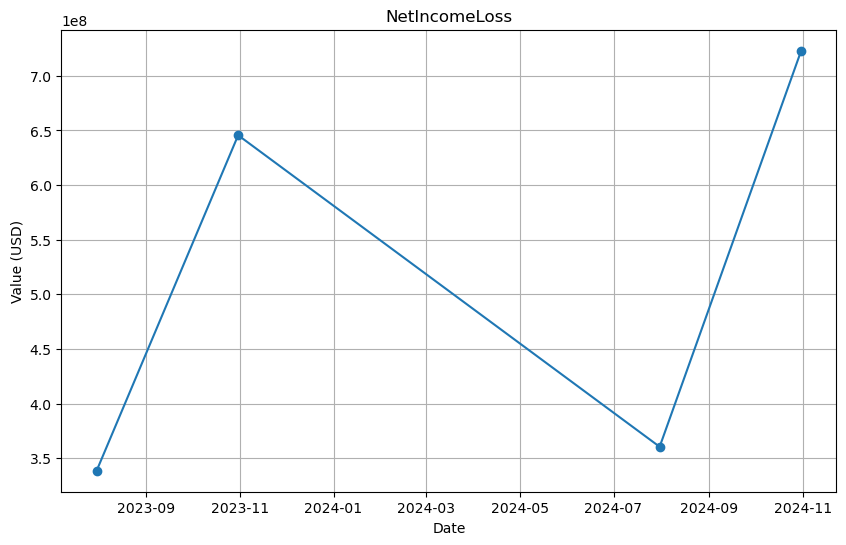

In [5]:

filtered_tags = num_user_total.groupby('tag').filter(lambda x: len(x) >= 2)['tag'].unique() # filter of data with at least 2 points of same tag
num_user_plot  = num_user_total[num_user_total['tag'].isin(filtered_tags)].sort_values(by=['tag','ddate']) # filter num_user_total using filter_tags

uom_dropdown = widgets.Dropdown(
    options=num_user_plot['uom'].drop_duplicates(keep='first').to_list(),
    description='Value type:',
    layout=widgets.Layout(width='400px', height='50px')
)

tag_dropdown = widgets.Dropdown(
    options=[],                     # !!! needs to start empty
    description='Tag:',
    layout=widgets.Layout(width='400px', height='50px')
)

# Function to update the tag dropdown based on the selected uom
def update_tag(change):
    selected_uom = change['new']
    tag_dropdown.options = num_user_plot[num_user_plot['uom']==uom_dropdown.value]['tag'].drop_duplicates(keep='first')

uom_dropdown.observe(update_tag, names='value')
tag_dropdown.options = num_user_plot[num_user_plot['uom']==uom_dropdown.value]['tag'].drop_duplicates(keep='first')

display(uom_dropdown, tag_dropdown)


# Define the function to plot the data
def plot_data(b):
    clear_output(wait=True)  # Clear the output before displaying the new plot
    display(uom_dropdown, tag_dropdown, plot_button) # Display the buttons again after plotting
    plt.figure(figsize=(10, 6))
    plt.plot(num_user_plot[(num_user_plot['tag']==tag_dropdown.value)&(num_user_plot['uom']==uom_dropdown.value)]['ddate'], 
             num_user_plot[(num_user_plot['tag']==tag_dropdown.value)&(num_user_plot['uom']==uom_dropdown.value)]['value'],
             marker='o')
    plt.xlabel('Date')
    plt.ylabel(f'Value ({uom_dropdown.value})')
    plt.title(f'{tag_dropdown.value}')
    plt.grid(True)
    plt.show()

# Create a button widget
plot_button = widgets.Button(description="Click to Plot")

# Add the function to the button's 'on_click' event
plot_button.on_click(plot_data)

display(plot_button)
